<a href="https://colab.research.google.com/github/ShudraRuslan/DSSLab1/blob/main/%D0%A8%D1%83%D0%B4%D1%80%D0%B0%D0%9A%D0%9086_%D0%9B%D0%B0%D0%B11_%D0%A1%D0%9F%D0%9F%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import tensorflow as tf
import typing as tp
import os

In [ ]:
 
 
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
plt.rcParams['figure.figsize'] = [16, 8]

# Модели и обертки

1. Создадим класс наследующий базовую модель keras с параметрами модели
2. Определим основной метод расчета исходного значения


In [ ]:
class Model(tf.keras.Model):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    self.theta_1 = tf.Variable([[0.01]])
    self.theta_2 = tf.Variable([[0.01]])
    self.theta_3 = tf.Variable([[0.01]])
    self.theta_4 = tf.Variable([[0.01]])

  def __call__(self, x,**kwargs):
    return tf.reduce_sum(tf.multiply(tf.pow(x, 3), self.theta_1) + 
            tf.multiply(tf.pow(x, 2), self.theta_2) + 
            tf.multiply(x, self.theta_3) + 
            self.theta_4, axis=1, keepdims=True)



1.  Определим класс обертку над моделью, где будем выполнять дополнительные действия: сохранять значения весов, считать функцию потерь
2.  Добавим базовый функцилнал настройки и оценки модели



In [ ]:
class ModelWrapper:
  def __init__(self):
    self.model = Model()
    self.loss_func = tf.keras.losses.mean_squared_error
    self.params = dict()
    self.cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=0)
    
  def get_loss(self, x_val, y_val):
    return tf.reduce_mean(tf.square(
        tf.Variable(y_val, dtype=tf.float32) - 
        self.model(tf.Variable(x_val, dtype=tf.float32))
        ))

  def add_l2_to_loss(self, loss_function, weights_for_normalization, l2_rate):
    def l2(weight):
      return tf.reduce_sum(tf.square(weight))
    def l2_loss(y_actual,y_pred):
      base_loss = loss_function(y_actual,y_pred)
      return base_loss + l2_rate * tf.reduce_sum(tf.map_fn(l2, tf.stack(weights_for_normalization, axis=0)))
    return l2_loss

  def compile(self, learning_rate, l2_rate):
    self.loss_func = self.add_l2_to_loss(tf.keras.losses.mean_squared_error, self.model.weights, l2_rate)
    self.model.compile(
        run_eagerly=False,
        optimizer=tf.keras.optimizers.SGD(learning_rate),
        loss=self.loss_func,
    )

  def __call__(self, x):
    return self.model(x)

  def fit(self, x, y, epochs, learning_rate, batch_size, l2_rate):
    self.params = {"epochs": epochs, "learning_rate": learning_rate, "batch_size": batch_size, "l2_rate": l2_rate}
    self.compile(learning_rate, l2_rate)
    self.model.fit(x, y, epochs, batch_size, verbose=0,callbacks=[self.cp_callback])




1.   Создадим класс для грид-поиска гиперпараметров: коеффициента регуляризации, количества мини-пакетов
2.   Определим базовые методы перебора



In [ ]:
class Tuner:
  def __init__(self, params, model_builder):
    self.model_builder = model_builder
    self.params = params
    self.models = []

  def param_seq(self):
    grid = [list()]
    for v in self.params.values():
      new_grids = []
      for item in v:
        new_grid = []
        for grid_item in grid:
          new_grid.append(grid_item + [item])
        new_grids += new_grid
      grid = new_grids
    seq = []
    for v in grid:
      param = dict()
      for k, item in zip(self.params.keys(), v):
        param[k] = item
      seq.append(param)
    return seq

  def evaluate(self, x_train, y_train, x_val, y_val):
    seq = self.param_seq()
    results = []
    for param in seq:
      model = self.model_builder()
      model.fit(x_train, y_train, **param)
      local_result = model.get_loss(x_val, y_val)
      results.append((model, local_result))
      print(f"mse for {param} is {local_result.numpy()}")
    return min(results, key=lambda x: x[1])

# Первый набор данных

In [ ]:
def make_data():
  X = np.linspace(-1,1,101) 
  num_coef=10 
  coef =[ -100 ,2 ,3 , -3000 ,5 ,6 ,4 ,300 ,2 ,600] 
  y=0 
  for i in range ( num_coef ) : 
    y += coef[ i ] * np.power (X, i ) 
    y += np.random.randn (*X.shape)* 100.5 

  return X, y

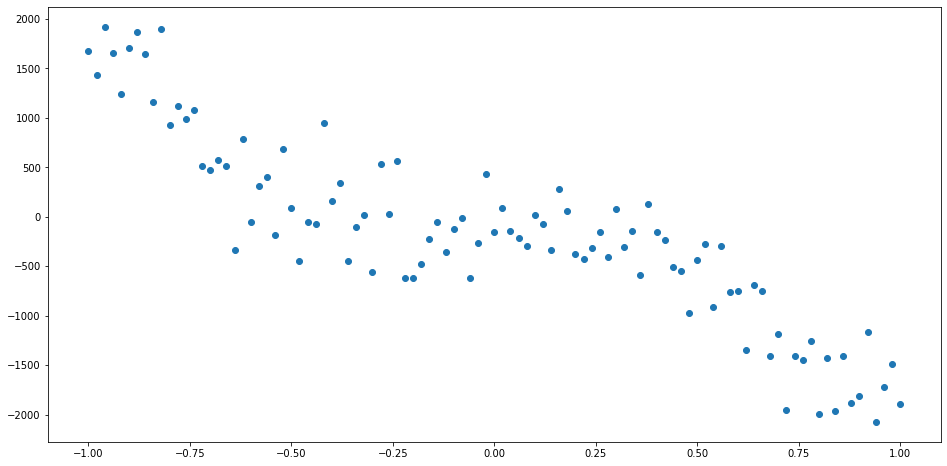

In [ ]:
X, y = make_data()
plt.scatter(X, y)

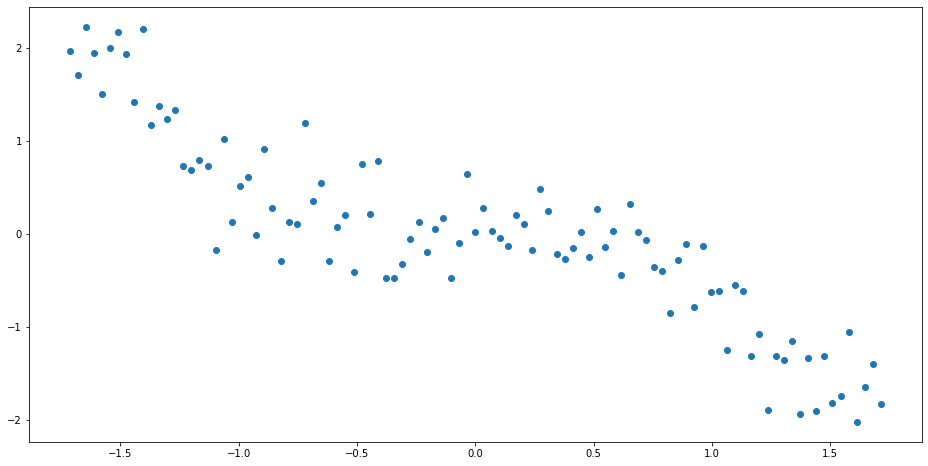

In [ ]:
X=X.reshape(-1,1)
y=y.reshape(-1,1)
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
scaler=StandardScaler().fit(y)
y=scaler.transform(y)
x_train, x_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test_dev, y_test_dev, test_size=0.2)
plt.scatter(X, y)

In [ ]:
tuner = Tuner({
    "epochs": [100],
    "learning_rate": [0.01, 0.02, 0.05,0.1],
    "batch_size": [10, 20, 30,50],
    "l2_rate": [0.01, 0.05, 0.1]
  },
  model_builder = ModelWrapper
)

In [ ]:
best_model, val_loss = tuner.evaluate(x_train, y_train, x_val, y_val)

mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 10, 'l2_rate': 0.01} is 0.3590105175971985
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 10, 'l2_rate': 0.01} is 0.12459214776754379
mse for {'epochs': 100, 'learning_rate': 0.05, 'batch_size': 10, 'l2_rate': 0.01} is 0.0651225596666336
mse for {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 10, 'l2_rate': 0.01} is 0.06520877033472061
mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 20, 'l2_rate': 0.01} is 0.13361023366451263
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 20, 'l2_rate': 0.01} is 0.06985612213611603
mse for {'epochs': 100, 'learning_rate': 0.05, 'batch_size': 20, 'l2_rate': 0.01} is 0.06519057601690292
mse for {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 20, 'l2_rate': 0.01} is 0.06633146852254868
mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 30, 'l2_rate': 0.01} is 0.08447100967168808
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size'

In [ ]:
print(f"best model params is {best_model.params} with total_val_loss = {val_loss}")

best model params is {'epochs': 100, 'learning_rate': 0.05, 'batch_size': 10, 'l2_rate': 0.01} with total_val_loss = 0.0651225596666336


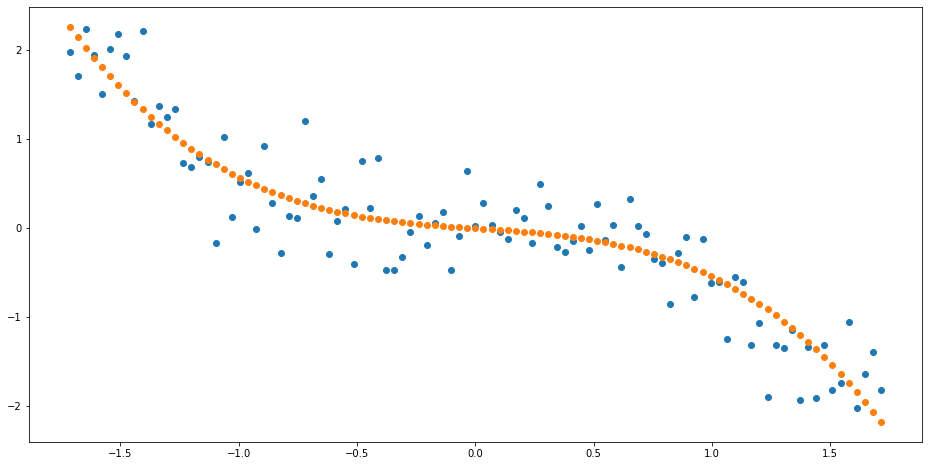

In [ ]:
model_y_test = best_model(tf.Variable(X, dtype=tf.float32))
plt.scatter(X, y)
plt.scatter(X, model_y_test)

# Второй набор данных

In [ ]:
from sklearn.datasets import make_friedman2 

In [ ]:
dataset = make_friedman2()

In [ ]:
data = dataset[0]
target = dataset[1].reshape(-1,1)

In [ ]:
scaler = StandardScaler().fit(data)
data=scaler.transform(data)
scaler=StandardScaler().fit(target)
target=scaler.transform(target)
x_train, x_test_dev, y_train, y_test_dev = train_test_split(data, target, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test_dev, y_test_dev, test_size=0.2)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
X_reduced=pca.fit_transform(data)


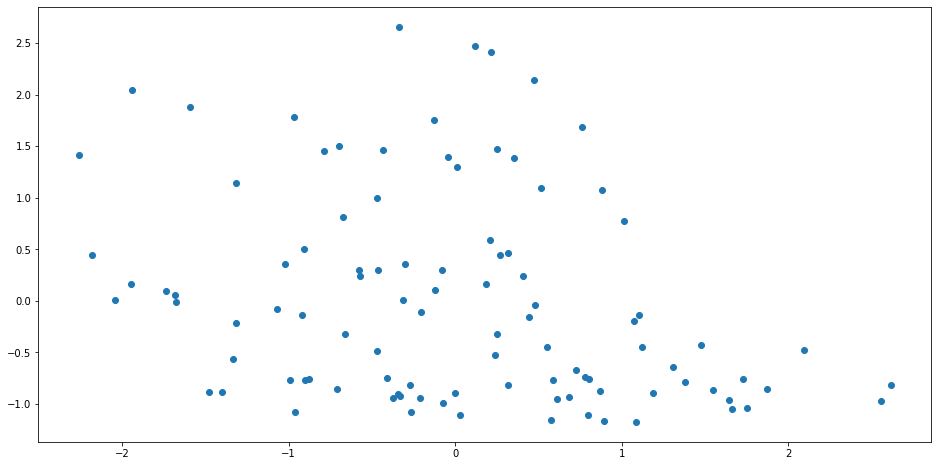

In [ ]:
plt.scatter(X_reduced,target)

In [ ]:
tuner = Tuner({
    "epochs": [100],
    "learning_rate": [0.01, 0.02, 0.05,0.1],
    "batch_size": [10, 20, 30,50],
    "l2_rate": [0.01, 0.05, 0.1]
  },
  model_builder = ModelWrapper
)

In [ ]:
best_model, val_loss = tuner.evaluate(x_train, y_train, x_val, y_val)

mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 10, 'l2_rate': 0.01} is 0.1889665722846985
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 10, 'l2_rate': 0.01} is 0.18489080667495728
mse for {'epochs': 100, 'learning_rate': 0.05, 'batch_size': 10, 'l2_rate': 0.01} is 579819.6875
mse for {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 10, 'l2_rate': 0.01} is 30494657871872.0
mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 20, 'l2_rate': 0.01} is 0.18489110469818115
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 20, 'l2_rate': 0.01} is 0.17880773544311523
mse for {'epochs': 100, 'learning_rate': 0.05, 'batch_size': 20, 'l2_rate': 0.01} is 10532208771072.0
mse for {'epochs': 100, 'learning_rate': 0.1, 'batch_size': 20, 'l2_rate': 0.01} is 2.9674571787883177e+28
mse for {'epochs': 100, 'learning_rate': 0.01, 'batch_size': 30, 'l2_rate': 0.01} is 0.18146418035030365
mse for {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 30, 'l2_

In [ ]:
print(f"best model params is {best_model.params} with total_val_loss = {val_loss}")

best model params is {'epochs': 100, 'learning_rate': 0.02, 'batch_size': 50, 'l2_rate': 0.01} with total_val_loss = 0.17233791947364807


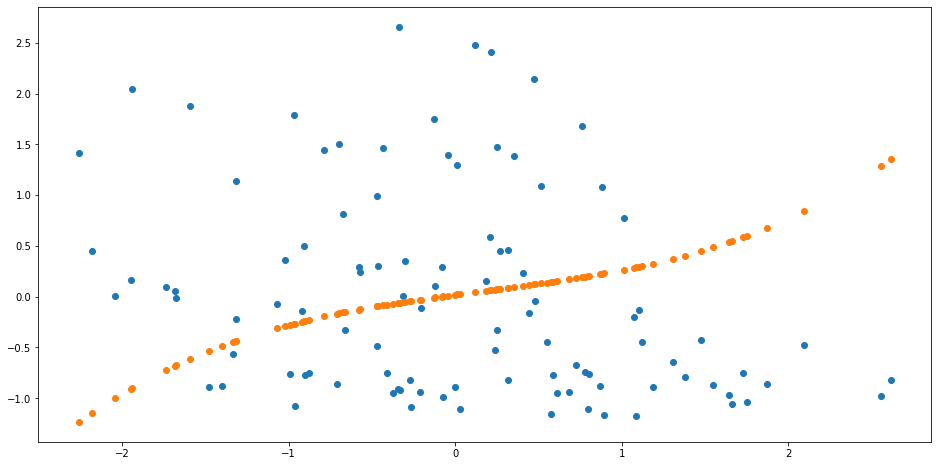

In [ ]:
model_y_test = best_model(tf.Variable(X_reduced, dtype=tf.float32))
plt.scatter(X_reduced, target)
plt.scatter(X_reduced, model_y_test)